In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar100

In [2]:
(train_data, train_label), (test_data, test_label) = cifar100.load_data()

In [3]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
import tensorflow.contrib.slim as slim
import os
import tensorflow.contrib as tf_contrib
import random
from scipy import misc
%matplotlib inline
import matplotlib.pyplot as plt

train_data = (train_data / 255.0)
test_data = (test_data / 255.0)

In [5]:
train_label = tf.squeeze(tf.one_hot(train_label, 100),axis=1)
test_label = tf.squeeze(tf.one_hot(test_label, 100),axis=1)

In [6]:
print(train_label.shape)
print(test_label.shape)

(50000, 100)
(10000, 100)


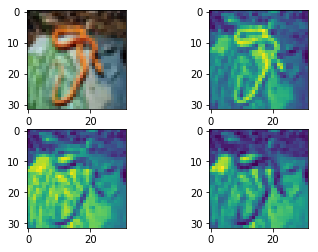

In [7]:
# show data
_, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
sample_data = train_data[49]
ax1.imshow(sample_data);
ax2.imshow(sample_data[:,:,0]);
ax3.imshow(sample_data[:,:,1]);
ax4.imshow(sample_data[:,:,2]);

In [8]:
def model(X, by):
    weight_init = tf.contrib.layers.xavier_initializer()
    weight_regularizer = tf_contrib.layers.l2_regularizer(0.009)
    with tf.variable_scope("first"):
        
        outs = tf.layers.conv2d(X, 32, 3, padding = "same")
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-2)
        outs = tf.nn.relu(outs)
        shortcut = outs
        
        shortcut = tf.layers.conv2d(shortcut, 32, 1, strides = (1, 1), padding = "same")
        outs = tf.layers.conv2d(outs, 32, 3, padding = "same")
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-2)
        outs = tf.nn.relu(outs)
        outs = tf.layers.conv2d(outs, 32, 3, padding = "same")
        outs += shortcut
        shortcut = outs
        
        shortcut = tf.layers.conv2d(shortcut, 64, 1, strides = (2, 2), padding = "same")
        outs = tf.layers.conv2d(outs, 64, 3, strides = (2, 2), padding = "same")
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-3)
        outs = tf.nn.relu(outs)
        outs = tf.layers.conv2d(outs, 64, 3, strides = (1, 1), padding = "same")
        outs += shortcut
        shortcut = outs
        
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-3)
        outs = tf.nn.relu(outs)
        outs = tf.layers.conv2d(outs, 64, 3, strides = (1, 1), padding = "same")
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-3)
        outs = tf.nn.relu(outs)
        outs = tf.layers.conv2d(outs, 64, 3, strides = (1, 1), padding = "same")
        outs += shortcut
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-3)
        outs = tf.nn.relu(outs)
        shortcut = outs
        
        shortcut = tf.layers.conv2d(shortcut, 128, 1, strides = (2, 2), padding = "same")
        outs = tf.layers.conv2d(outs, 128, 3, strides = (2, 2), padding = "same")
        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-3)
        outs = tf.nn.relu(outs)
        outs = tf.layers.conv2d(outs, 128, 3, strides = (1, 1), padding = "same")
        outs += shortcut

        outs = tf.layers.batch_normalization(outs, momentum=0.99, epsilon=1e-3)
        outs = tf.nn.relu(outs)
        
        
    outs = tf.layers.average_pooling2d(outs, 8, 1, padding = "same")
    #outs = tf.reduce_mean(outs, axis=[1, 2], keepdims=True)

    outs = tf.reshape(outs, (-1, outs.shape[1] * outs.shape[2] * outs.shape[3]))

    outs = tf.layers.dense(outs, 100, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, use_bias=True)
   
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = by, logits =outs)
    loss = tf.reduce_mean(loss)
    
    opt = tf.train.MomentumOptimizer(0.009, momentum=0.99).minimize(loss)
    preds = tf.equal(tf.argmax(tf.nn.softmax(outs), 1), tf.argmax(by, 1))
    acc = tf.reduce_mean(tf.cast(preds, tf.float32))
    
    return {
        "loss" : loss,
        "opt" : opt,
        "preds" : preds,
        "acc" : acc
    }

In [9]:
X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
by = tf.placeholder(tf.float32, shape = [None, 100])

ours = model(X, by)

init = tf.global_variables_initializer()

In [10]:
num_epochs = 15
batch_size = 512
num_display = 50
num_samples = 51200

In [11]:
with tf.Session() as sess:
    sess.run(init)
    for ind_epoch in range(0, num_epochs):
        print("Curent iteration {}".format(ind_epoch +1))
        for ind_ in range(0, int(num_samples/batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label.eval()[ind_*batch_size:(ind_+1)*batch_size]
            
            _, cur_loss, cur_acc = sess.run([ours["opt"], ours["loss"], ours["acc"]], feed_dict = {X : batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print("loss {0:.4f} acc {1:.4f}".format(cur_loss, cur_acc))
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    for ind_ in range(0 , 10):
        cur_loss, cur_acc = sess.run([ours["loss"], ours["acc"]], feed_dict = {X : test_data[ind_ * 1000:(ind_+1) *1000], by : test_label.eval()[ind_ * 1000: (ind_ +1) *1000]})
        cur_acc_all += cur_acc
        cur_loss_all += cur_loss
    print('===============================')
    print("Test: less {0:.4f} acc {1:.4f}".format(cur_loss_all/ 10.0, cur_acc_all/ 10.0))      
                

Curent iteration 1
loss 4.6078 acc 0.0078
loss 4.5577 acc 0.0176
Curent iteration 2
loss 4.3437 acc 0.0352
loss 4.1474 acc 0.0684
Curent iteration 3
loss 3.9562 acc 0.0801
loss 3.8262 acc 0.1113
Curent iteration 4
loss 3.7873 acc 0.1309
loss 3.5820 acc 0.1387
Curent iteration 5
loss 3.5476 acc 0.1660
loss 3.3040 acc 0.2363
Curent iteration 6
loss 3.2406 acc 0.2324
loss 3.1227 acc 0.2539
Curent iteration 7
loss 3.1303 acc 0.2637
loss 2.9267 acc 0.3105
Curent iteration 8
loss 2.9811 acc 0.2676
loss 2.7948 acc 0.3066
Curent iteration 9
loss 2.9232 acc 0.2852
loss 2.7441 acc 0.3145
Curent iteration 10
loss 2.6969 acc 0.3359
loss 2.5334 acc 0.3789
Curent iteration 11
loss 2.5691 acc 0.3652
loss 2.5024 acc 0.3418
Curent iteration 12
loss 2.4923 acc 0.3770
loss 2.4146 acc 0.3887
Curent iteration 13
loss 2.3803 acc 0.3867
loss 2.3301 acc 0.4141
Curent iteration 14
loss 2.3344 acc 0.3984
loss 2.2192 acc 0.4219
Curent iteration 15
loss 2.1844 acc 0.4297
loss 2.1168 acc 0.4551
Test: less 2.5119 a